In [1]:
from pathlib import Path
import pickle
from games.smb1Py.py_mario_bros.PythonSuperMario_master.source import tools
import games.smb1Py.py_mario_bros.PythonSuperMario_master.source.constants as c
from games.smb1Py.py_mario_bros.PythonSuperMario_master.source.states.segment import Segment, SegmentState
from play_level import LevelCheckpoint, annulus;
import numpy as np
from skimage.io import imshow

pygame 2.1.2 (SDL 2.0.18, Python 3.10.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


c:\Users\Harrison Truscott\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\distributed\distributed_c10d.py:181: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


In [2]:
checkpoint_loc = "test_level_play_t4.chp";
level_path = Path('levels')/'testing'/'test3.lvl';

level = SegmentState(None,None,file_path=level_path);

with open(checkpoint_loc,'rb') as f:
    check:LevelCheckpoint = pickle.load(f);

preds = check.pred;
costs = check.costs;

game = tools.Control()
state_dict = {c.LEVEL: Segment()}
game.setup_states(state_dict, c.LEVEL)
game.state.startup(0,{c.LEVEL_NUM:1},initial_state=level);

search_data_resolution=4
task_offset_downscale=1
view_distance = 3.75;
tile_scale = 2;

gdat = game.get_game_data(view_distance,tile_scale);
mdat = game.get_map_data(search_data_resolution);

player_start:tuple[float,float] = gdat['pos'];
search_grids = [np.array(mdat[g]) for g in ['collision_grid']];
grid_size = search_grids[0].shape;
grids_bounds:tuple[int,int,int,int] =  mdat['grid_bounds'];

def get_cost(start:tuple[int,int],task:tuple[int,int]):
    # if mdat['collision_grid'][task[0]][task[1]] != 0:
    #     return float('inf');
    if (not in_bounds(task)):
        return float('inf');
    if (start,task) in costs:
        return costs[start,task];
    elif (start,task) not in preds:
        if mdat['collision_grid'][task[0]][task[1]] != 0:
            return float('inf');
        else:
            return(get_cost(start,(task[0]-1,task[1]-1)));
        raise Exception("Error: cannot evaluate fixed net outside of play conditions");
        self.predictions[start,task] = cost_from_fitness(dist(*grid_index_to_pos(start),grid_index_to_pos(task))*self.eval_fixed_net(search_grids,start,task,grid_size));
    return preds[start,task];

min_dist = 8; max_dist = 40
task_offsets = [(s[0]*task_offset_downscale,s[1]*task_offset_downscale) for s in annulus(min_dist/task_offset_downscale,max_dist/task_offset_downscale)]

def get_costs(pos)->np.ndarray:
    out_grid = np.ndarray(grid_size);
    out_grid.fill(0);
    # center = (max_dist,max_dist);
    for offset in task_offsets:
        task = (pos[0]+offset[0],pos[1]+offset[1]);
        if (in_bounds(task) and (pos,task) in costs):
            out_grid[task] = costs[pos,task]+0.2;
    out_grid[out_grid==float('inf')] = 0.1;
    return out_grid;

def get_preds(pos)->np.ndarray:
    out_grid = np.ndarray(grid_size);
    out_grid.fill(0);
    # center = (max_dist,max_dist);
    for offset in task_offsets:
        task = (pos[0]+offset[0],pos[1]+offset[1]);
        if (in_bounds(task) and (pos,task) in preds):
            out_grid[task] = preds[pos,task]+0.2;
    out_grid[out_grid==float('inf')] = 0.1;
    return out_grid;

def get_heuristic(pos)->np.ndarray:
    out_grid = np.ndarray(grid_size);
    out_grid.fill(0);
    # center = (max_dist,max_dist);
    for offset in task_offsets:
        task = (pos[0]+offset[0],pos[1]+offset[1]);
        if (in_bounds(task) and (pos,task) in preds):
            out_grid[task] = preds[pos,task]+0.2;
    out_grid[out_grid==float('inf')] = 0.1;
    return out_grid;

def in_bounds(pos:tuple[int,int]):
    return pos[0] >= 0 and pos[0] < grid_size[0] and pos[1] >= 0 and pos[1] < grid_size[1];

def pos_to_grid_index(pos:tuple[float,float]):
    pos = pos[0]-c.TILE_SIZE/(2*search_data_resolution),pos[1]-c.TILE_SIZE/(2*search_data_resolution);
    position_parameter = ((pos[0]-grids_bounds[0])/(grids_bounds[1]-grids_bounds[0]),(pos[1]-grids_bounds[2])/(grids_bounds[3]-grids_bounds[2]));
    closest_pixel = (int(position_parameter[0]*grid_size[0]),int(position_parameter[1]*grid_size[1]))
    return closest_pixel;

In [3]:
def show_image(im):
    imshow(im.transpose())

c:\Users\Harrison Truscott\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[20, 260]
(1, 25)
(200, 60)


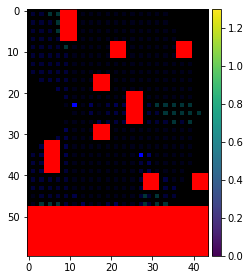

In [4]:
import matplotlib.pyplot as plt
# p2 = (415,255);
start = pos_to_grid_index(player_start);
print(player_start);
print(start);
a = get_costs(start);
b = get_preds(start);
c = get_heuristic(start);
print(a.shape);

cost_pad = max_dist+2;
bounds = [max(start[0]-cost_pad,0),min(start[0]+cost_pad,grid_size[0]-1),max(start[1]-cost_pad,0),min(start[1]+cost_pad,grid_size[1]-1)];
a = a[bounds[0]:bounds[1]+1,bounds[2]:bounds[3]+1];
b = b[bounds[0]:bounds[1]+1,bounds[2]:bounds[3]+1];
display_grid = np.array(search_grids[0])[bounds[0]:bounds[1]+1,bounds[2]:bounds[3]+1];
display_grids:np.ndarray = np.concatenate(([display_grid,a,b],),axis=0);

show_image(display_grids);
# print(np.min(a),np.max(a));

0.20678391969084722


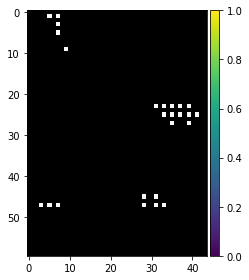

In [9]:
print(np.max(a[a<0.209]));
show_image(np.array((a,a,a))/np.max(a))

c:\Users\Harrison Truscott\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.21004408709500955
92


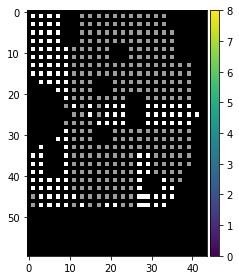

In [10]:
print(np.min(b[b>0.21]))
print(np.count_nonzero(b>0.21))
show_image(np.array((b,b,b))/np.max(b)*8)